# Group Assignment #4 Part 2 #

# Point Pattern Analysis (LA Crime)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata

# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

In [2]:
# Loads crime data from LAPD using Socrata- Crime data from 2020 to present

# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("2nrs-mtv8", 
                     limit=50000,
                     where = "date_rptd >= '2020-09-01T00:00:00'",
                     order='date_rptd desc')

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [3]:
df.shape

(46482, 28)

In [4]:
#convert pandas dataframe to geodataframe 

df = gpd.GeoDataFrame(df, 
                     crs='EPSG:4326',
                     geometry=gpd.points_from_xy(df.lon, df.lat))

In [5]:
# convert lat/lon to floats
df.lon = df.lon.astype('float')
df.lat = df.lat.astype('float')
df.vict_age = df.vict_age.astype('int')

In [6]:
# drop the unmapped rows
df.drop(df[df.lon==0].index,inplace=True)

In [7]:
df

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,location,lat,lon,weapon_used_cd,weapon_desc,cross_street,crm_cd_2,crm_cd_3,crm_cd_4,geometry
0,201518129,2020-11-30T00:00:00.000,2020-11-02T00:00:00.000,1400,15,N Hollywood,1527,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,6100 FULCHER AV,34.1813,-118.3732,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.37320 34.18130)
1,201518116,2020-11-30T00:00:00.000,2020-11-29T00:00:00.000,1200,15,N Hollywood,1563,1,310,BURGLARY,...,4400 IRVINE AV,34.1504,-118.3855,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.38550 34.15040)
2,200121703,2020-11-30T00:00:00.000,2020-11-30T00:00:00.000,0145,01,Central,0101,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,BEAUDRY,34.0655,-118.2489,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",SUNSET,NaN,NaN,NaN,POINT (-118.24890 34.06550)
4,200716533,2020-11-30T00:00:00.000,2020-11-26T00:00:00.000,1130,07,Wilshire,0745,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,SAN VICENTE BL,34.0527,-118.3509,NaN,NaN,COCHRAN AV,NaN,NaN,NaN,POINT (-118.35090 34.05270)
5,200618640,2020-11-30T00:00:00.000,2020-11-27T00:00:00.000,1900,06,Hollywood,0663,1,210,ROBBERY,...,6700 SANTA MONICA BL,34.0907,-118.3368,102,HAND GUN,NaN,NaN,NaN,NaN,POINT (-118.33680 34.09070)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46477,201914044,2020-09-01T00:00:00.000,2020-09-01T00:00:00.000,2230,19,Mission,1983,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,8500 BURNET AV,34.2246,-118.4633,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",NaN,NaN,NaN,NaN,POINT (-118.46330 34.22460)
46478,200316628,2020-09-01T00:00:00.000,2020-09-01T00:00:00.000,1600,03,Southwest,0363,2,922,CHILD STEALING,...,4100 PALMWOOD DR,34.0137,-118.3435,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.34350 34.01370)
46479,201612510,2020-09-01T00:00:00.000,2020-09-01T00:00:00.000,1540,16,Foothill,1638,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,10600 PINEWOOD AV,34.2611,-118.2857,305,FIXED OBJECT,NaN,NaN,NaN,NaN,POINT (-118.28570 34.26110)
46480,200614815,2020-09-01T00:00:00.000,2020-09-01T00:00:00.000,2235,06,Hollywood,0656,2,888,TRESPASSING,...,6000 BARTON AV,34.0880,-118.3258,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.32580 34.08800)


In [8]:
# filter columns
df=df[['date_rptd','area_name','vict_age','vict_sex','vict_descent','crm_cd_desc','geometry']]

In [9]:
# rename columns
df.columns = ['date','area_name','age','sex','race','crime','geometry']

In [10]:
# project to web mercator
df=df.to_crs('EPSG:3857')

In [11]:
# drop rows with null values
df = df.dropna()

In [12]:
# drop rows where age == 0
df = df[df.age!=0]

In [13]:
df.shape

(34640, 7)

In [14]:
df.sample(10)

,date,area_name,age,sex,race,crime,geometry
28353,2020-10-05T00:00:00.000,Wilshire,28,F,W,BURGLARY FROM VEHICLE,POINT (-13177010.577 4038796.509)
28819,2020-10-04T00:00:00.000,Wilshire,48,M,W,ATTEMPTED ROBBERY,POINT (-13176676.618 4037506.405)
29138,2020-10-04T00:00:00.000,Newton,33,M,H,BATTERY - SIMPLE ASSAULT,POINT (-13166502.017 4027419.072)
37090,2020-09-18T00:00:00.000,Pacific,42,F,O,BURGLARY FROM VEHICLE,POINT (-13180795.439 4031890.782)
38361,2020-09-16T00:00:00.000,Hollywood,36,M,B,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),POINT (-13173737.784 4042318.160)
45127,2020-09-03T00:00:00.000,Southwest,18,X,X,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",POINT (-13173871.367 4032978.761)
7159,2020-11-16T00:00:00.000,Central,34,F,H,BATTERY WITH SEXUAL CONTACT,POINT (-13164175.439 4035396.863)
2030,2020-11-25T00:00:00.000,Wilshire,65,F,W,CRIMINAL THREATS - NO WEAPON DISPLAYED,POINT (-13178068.112 4039119.057)
30950,2020-09-30T00:00:00.000,Southeast,37,F,B,BURGLARY,POINT (-13165155.051 4022962.533)
10948,2020-11-08T00:00:00.000,Rampart,21,F,B,BATTERY - SIMPLE ASSAULT,POINT (-13167069.746 4038487.408)


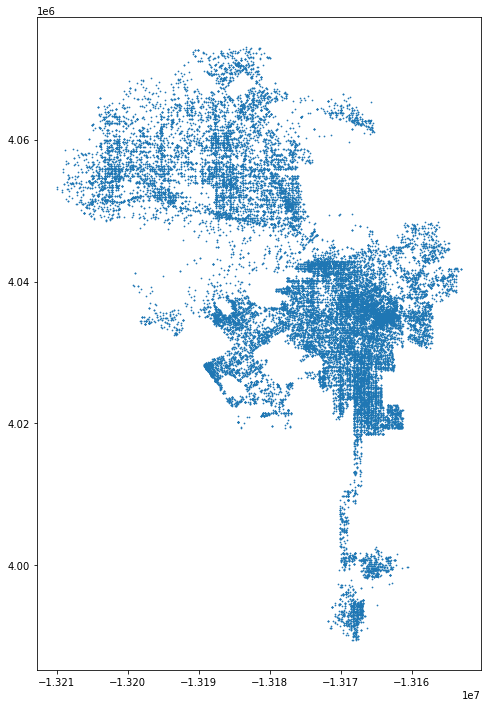

In [15]:
#Provides a plot of the single points for crime in Los Angeles - Heat Maps
df.plot(figsize=(12,12),
             markersize=0.5)

In [16]:
# import the interact library to interactively explore the dataset
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [17]:
#creates a list of the crime types
df.crime.value_counts()


BATTERY - SIMPLE ASSAULT                                   3835
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             3014
INTIMATE PARTNER - SIMPLE ASSAULT                          2528
BURGLARY FROM VEHICLE                                      2500
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    2222
                                                           ... 
DOCUMENT WORTHLESS ($200 & UNDER)                             1
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE                     1
MANSLAUGHTER, NEGLIGENT                                       1
DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400             1
DRUNK ROLL                                                    1
Name: crime, Length: 110, dtype: int64

In [18]:
# get the top 50 crime types into a list
top_50_crimes = df.crime.value_counts().head(50).index.tolist()
top_50_crimes

['BATTERY - SIMPLE ASSAULT',
 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
 'INTIMATE PARTNER - SIMPLE ASSAULT',
 'BURGLARY FROM VEHICLE',
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
 'BURGLARY',
 'THEFT PLAIN - PETTY ($950 & UNDER)',
 'THEFT OF IDENTITY',
 'ROBBERY',
 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
 'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
 'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
 'BRANDISH WEAPON',
 'INTIMATE PARTNER - AGGRAVATED ASSAULT',
 'VIOLATION OF RESTRAINING ORDER',
 'BIKE - STOLEN',
 'TRESPASSING',
 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
 'VIOLATION OF COURT ORDER',
 'BUNCO, GRAND THEFT',
 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
 'OTHER MISCELLANEOUS CRIME',
 'BATTERY WITH SEXUAL CONTACT',
 'ATTEMPTED ROBBERY',
 'OTHER ASSAULT',
 'RAPE, FORCIBLE',
 'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
 'THEFT, PERSON',
 

In [19]:
#provides a slice of the data for the "intimate partner- simple assault" crime type
df[df.crime == 'INTIMATE PARTNER - SIMPLE ASSAULT'].head()


,date,area_name,age,sex,race,crime,geometry
2,2020-11-30T00:00:00.000,Central,29,F,B,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13163407.335 4037600.470)
20,2020-11-30T00:00:00.000,Central,58,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13162750.550 4033905.640)
40,2020-11-30T00:00:00.000,Southeast,55,F,B,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13162706.022 4020963.026)
143,2020-11-30T00:00:00.000,Northeast,44,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13164331.287 4039979.232)
175,2020-11-30T00:00:00.000,Mission,31,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13184357.663 4061289.322)


In [20]:
#provides a slice of the data for the "BURGLARY FROM VEHICLE" crime type
df[df.crime == 'BURGLARY FROM VEHICLE'].head()


,date,area_name,age,sex,race,crime,geometry
23,2020-11-30T00:00:00.000,N Hollywood,31,F,W,BURGLARY FROM VEHICLE,POINT (-13180327.897 4051934.327)
24,2020-11-30T00:00:00.000,Central,31,M,W,BURGLARY FROM VEHICLE,POINT (-13161882.258 4034966.941)
79,2020-11-30T00:00:00.000,Hollywood,28,M,W,BURGLARY FROM VEHICLE,POINT (-13174550.416 4042210.613)
97,2020-11-30T00:00:00.000,Foothill,30,M,W,BURGLARY FROM VEHICLE,POINT (-13176921.521 4057802.170)
150,2020-11-30T00:00:00.000,West LA,48,M,W,BURGLARY FROM VEHICLE,POINT (-13185270.483 4036565.797)


,date,area_name,age,sex,race,crime,geometry
2,2020-11-30T00:00:00.000,Central,29,F,B,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13163407.335 4037600.470)
20,2020-11-30T00:00:00.000,Central,58,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13162750.550 4033905.640)
40,2020-11-30T00:00:00.000,Southeast,55,F,B,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13162706.022 4020963.026)
143,2020-11-30T00:00:00.000,Northeast,44,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13164331.287 4039979.232)
175,2020-11-30T00:00:00.000,Mission,31,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13184357.663 4061289.322)


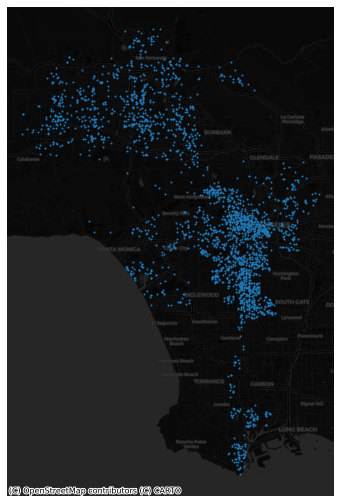

In [21]:
#This puts the data above into a table 
# table
display(df[df.crime == 'INTIMATE PARTNER - SIMPLE ASSAULT'].head()) 

# map
ax = df[df.crime == 'INTIMATE PARTNER - SIMPLE ASSAULT'].plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

,date,area_name,age,sex,race,crime,geometry
23,2020-11-30T00:00:00.000,N Hollywood,31,F,W,BURGLARY FROM VEHICLE,POINT (-13180327.897 4051934.327)
24,2020-11-30T00:00:00.000,Central,31,M,W,BURGLARY FROM VEHICLE,POINT (-13161882.258 4034966.941)
79,2020-11-30T00:00:00.000,Hollywood,28,M,W,BURGLARY FROM VEHICLE,POINT (-13174550.416 4042210.613)
97,2020-11-30T00:00:00.000,Foothill,30,M,W,BURGLARY FROM VEHICLE,POINT (-13176921.521 4057802.170)
150,2020-11-30T00:00:00.000,West LA,48,M,W,BURGLARY FROM VEHICLE,POINT (-13185270.483 4036565.797)


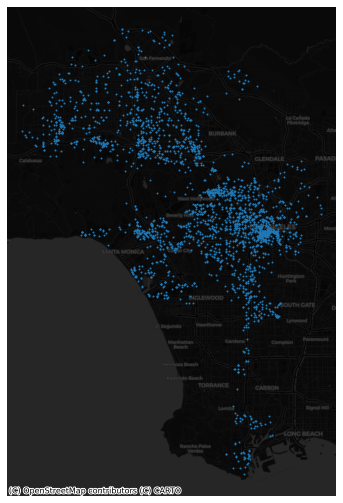

In [22]:
# table
display(df[df.crime == 'BURGLARY FROM VEHICLE'].head()) 

# map
ax = df[df.crime == 'BURGLARY FROM VEHICLE'].plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

,date,area_name,age,sex,race,crime,geometry
1,2020-11-30T00:00:00.000,N Hollywood,42,M,W,BURGLARY,POINT (-13178613.577 4049014.994)
8,2020-11-30T00:00:00.000,Mission,63,M,W,BURGLARY,POINT (-13187764.039 4058569.521)
11,2020-11-30T00:00:00.000,Pacific,39,M,W,BURGLARY,POINT (-13183133.149 4027137.131)
31,2020-11-30T00:00:00.000,West LA,60,M,O,BURGLARY,POINT (-13182988.433 4035840.238)
53,2020-11-30T00:00:00.000,N Hollywood,20,F,B,BURGLARY,POINT (-13173771.179 4047105.053)


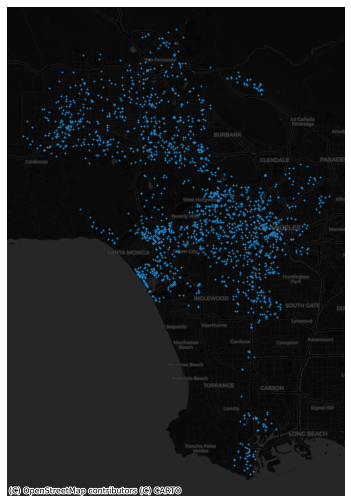

In [23]:
# table
display(df[df.crime == 'BURGLARY'].head()) 

# map
ax = df[df.crime == 'BURGLARY'].plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

In [24]:
# creates a function for the map outputs above
def crime_by(crime='INTIMATE PARTNER - SIMPLE ASSAULT'):
    # table
    display(df[df.crime == crime].head()) 
    
    # map
    ax = df[df.crime == crime].plot(figsize=(9,9), markersize=2)
    
    # axis
    ax.axis('off')
    
    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

,date,area_name,age,sex,race,crime,geometry
228,2020-11-30T00:00:00.000,Van Nuys,35,M,O,BIKE - STOLEN,POINT (-13182732.398 4048813.225)
617,2020-11-29T00:00:00.000,Central,29,F,H,BIKE - STOLEN,POINT (-13162962.057 4035598.395)
630,2020-11-29T00:00:00.000,Olympic,14,M,O,BIKE - STOLEN,POINT (-13168038.226 4038084.246)
862,2020-11-28T00:00:00.000,West LA,23,M,W,BIKE - STOLEN,POINT (-13179637.717 4033005.626)
929,2020-11-28T00:00:00.000,Central,42,M,H,BIKE - STOLEN,POINT (-13162138.293 4036337.375)


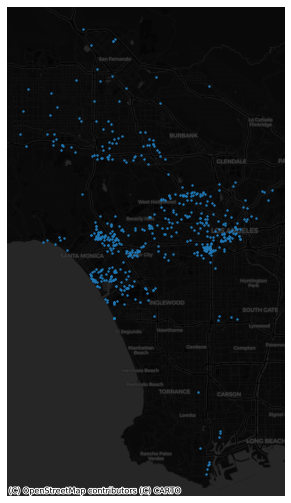

In [25]:
#uses the function to map a different crime type
crime_by(crime='BIKE - STOLEN')

In [26]:
#use interactive feature to create a drop down for the function
@interact

# function argument will become interactive
def arrests_by(crime=top_50_crimes):
    # table
    display(df[df.crime == crime].head()) 

    # map
    ax = df[df.crime == crime].plot(figsize=(9,9), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

interactive(children=(Dropdown(description='crime', options=('BATTERY - SIMPLE ASSAULT', 'ASSAULT WITH DEADLY …

In [27]:
# to make this function interactive
@interact

# function argument will become interactive
def arrests_by(crime=top_50_crimes,
               area=df.area_name.unique().tolist()):
    # table
    display(df[(df.crime == crime)&(df.area_name==area)].head()) 

    # map
    ax = df[(df.crime == crime)&(df.area_name==area)].plot(figsize=(9,9), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

interactive(children=(Dropdown(description='crime', options=('BATTERY - SIMPLE ASSAULT', 'ASSAULT WITH DEADLY …

In [28]:
df.race.unique().tolist()


['H',
 'W',
 'B',
 'O',
 'A',
 'X',
 'G',
 'V',
 'K',
 'F',
 'C',
 'J',
 'I',
 'S',
 'Z',
 'P',
 'D',
 'U']

In [29]:
# to make this function interactive
@interact

# function argument will become interactive
def arrests_by(crime=top_50_crimes,
               race=df.race.unique().tolist()):
    # table
    display(df[(df.crime == crime)&(df.race == race)].head()) 

    # map
    ax = df[(df.crime == crime)&(df.race==race)].plot(figsize=(9,9), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

interactive(children=(Dropdown(description='crime', options=('BATTERY - SIMPLE ASSAULT', 'ASSAULT WITH DEADLY …

In [30]:
#Using Seaborn to create KDE plot; first step to work in web mercator
df = df.to_crs('EPSG:3857')

In [31]:
# seaborn needs an x and y column so we can extract it from the geometry field
df['x'] = df.geometry.x
df['y'] = df.geometry.y

In [32]:
#This creates a subset for the race data
data_mini = df[df.race.isin(['H','B','W'])]

In [33]:
#This creates a subset for the crime data
data_mini2 = df[df.crime.isin(['INTIMATE PARTNER - SIMPLE ASSAULT','BURGLARY','BURGLARY FROM VEHICLE'])]

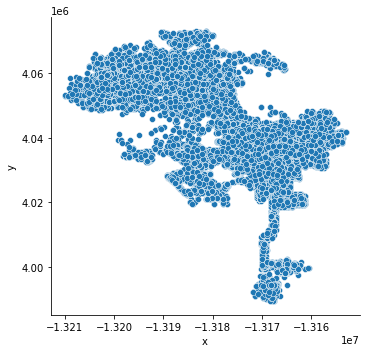

In [34]:
# scatterplot
sns.relplot(data=data_mini,
            x='x', 
            y='y')

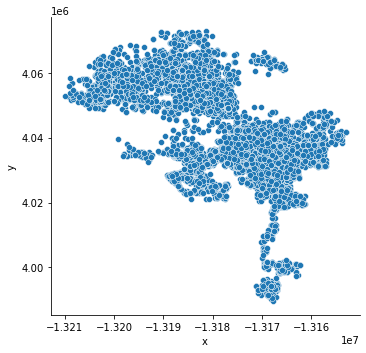

In [35]:
# scatterplot
sns.relplot(data=data_mini2,
            x='x', 
            y='y')

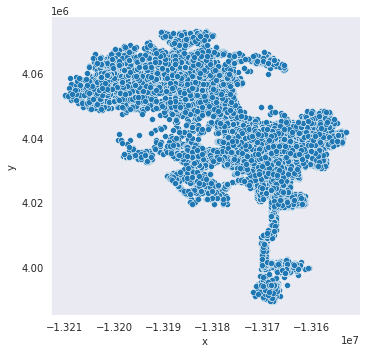

In [36]:
# seaborn themes to make them prettier
sns.set_style('dark')

# scatterplot 
sns.relplot(data=data_mini,
            x='x', 
            y='y')

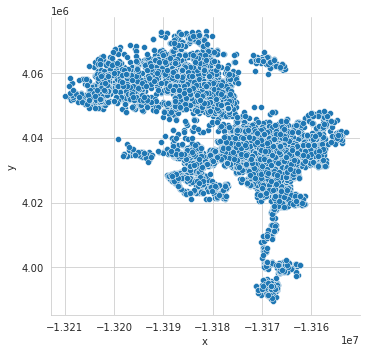

In [37]:
# seaborn themes to make them prettier
sns.set_style('whitegrid')

# scatterplot 
sns.relplot(data=data_mini2,
            x='x', 
            y='y')

In [38]:
@interact
def sns_styles(style=['darkgrid', 'whitegrid', 'dark', 'white', 'ticks']):
    # seaborn comes with themes to make them prettier
    sns.set_style(style)

    # scatterplot 
    sns.relplot(data=data_mini,
                x='x', 
                y='y')

interactive(children=(Dropdown(description='style', options=('darkgrid', 'whitegrid', 'dark', 'white', 'ticks'…

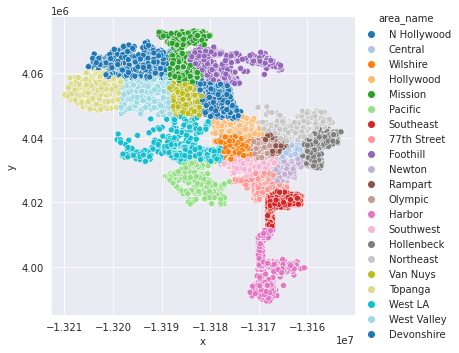

In [39]:
sns.relplot(data=data_mini,
            x='x', 
            y='y',
            hue='area_name',
            palette='tab20')

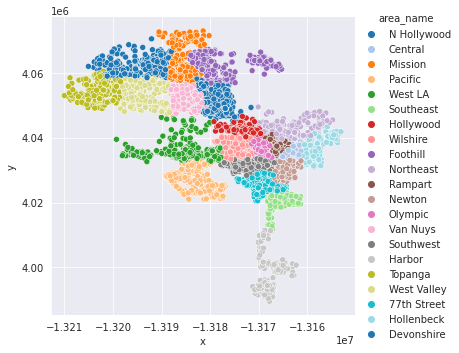

In [40]:
sns.relplot(data=data_mini2,
            x='x', 
            y='y',
            hue='area_name',
            palette='tab20')

In [41]:
color_list=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

In [42]:
@interact
def crime_areas(palette=color_list):
# scatterplot colored by area
    sns.relplot(data=data_mini,
                x='x', 
                y='y',
                hue='area_name',
                palette=palette)

interactive(children=(Dropdown(description='palette', options=('Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG…

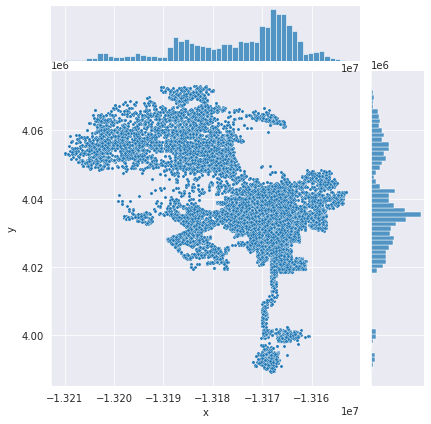

In [43]:
#Joint Plots 

# scatterplot with edges
g = sns.jointplot(data = data_mini,
                  x='x', 
                  y='y',
                  s=10)

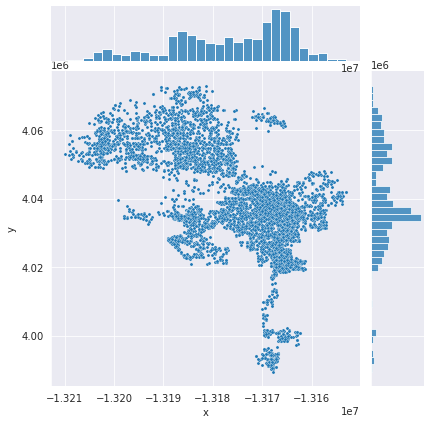

In [44]:
# scatterplot with edges
g2 = sns.jointplot(data = data_mini2,
                  x='x', 
                  y='y',
                  s=10)

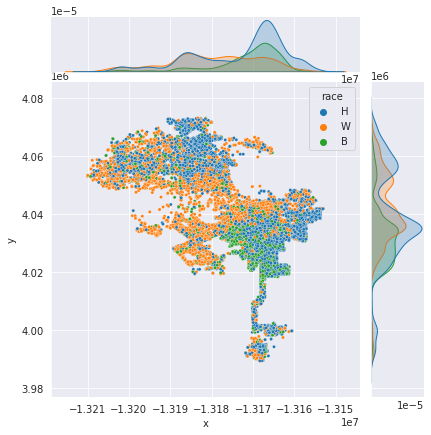

In [45]:
# color code by race
g = sns.jointplot(data = data_mini,
                  x='x', 
                  y='y',
                  hue='race',
                  s=10)

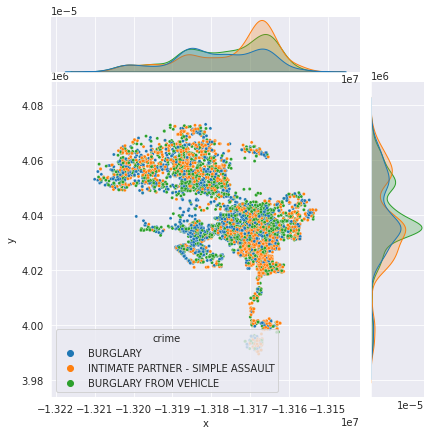

In [46]:
# color code by crime type
g2 = sns.jointplot(data = data_mini2,
                  x='x', 
                  y='y',
                  hue='crime',
                  s=10)

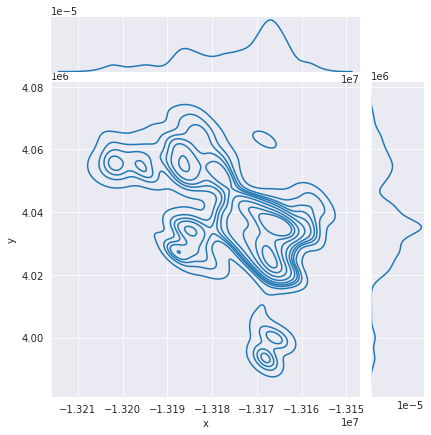

In [47]:
# kde plot
sns.jointplot(data = data_mini,
              x='x', 
              y='y', 
              kind='kde')

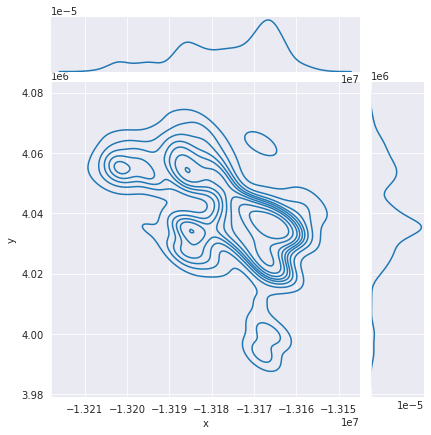

In [48]:
# kde plot number 2
sns.jointplot(data = data_mini2,
              x='x', 
              y='y', 
              kind='kde')

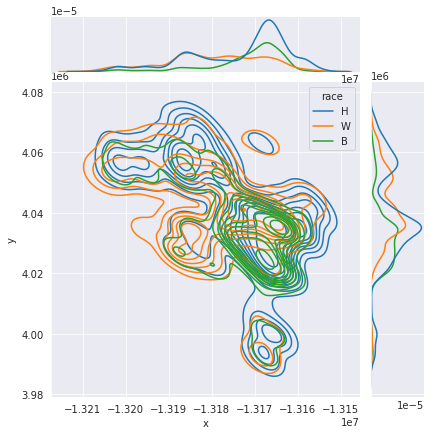

In [49]:
# multiple kde plots by race
sns.jointplot(data = data_mini,
              x='x', 
              y='y', 
              kind='kde',
              hue='race')

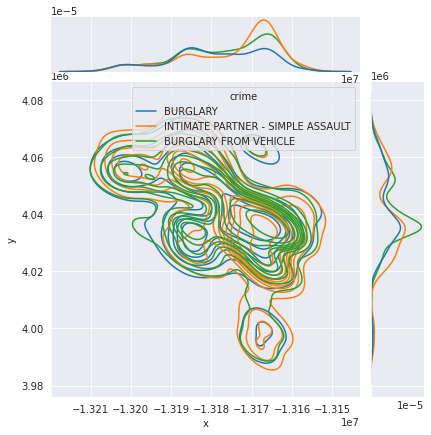

In [50]:
# multiple kde plots by crime
sns.jointplot(data = data_mini2,
              x='x', 
              y='y', 
              kind='kde',
              hue='crime')

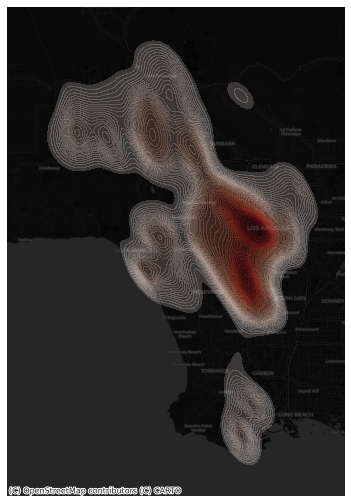

In [51]:
# Heat map with KDE Plots for race

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# kdeplot, i.e. heat map
sns.kdeplot(x = data_mini.x, 
            y = data_mini.y,
            n_levels=50, 
            shade=True,
            thresh=0.05,
            alpha=0.2, 
            cmap='Reds')

# axes
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

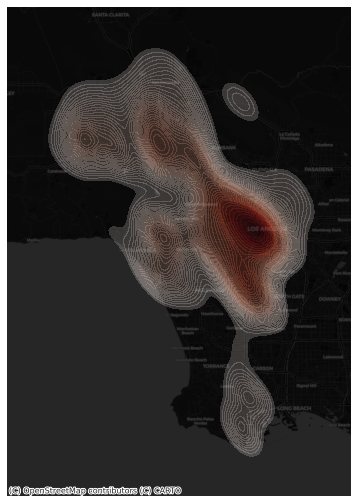

In [52]:
#Heat map with KDE Plot for Crime
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# kdeplot, i.e. heat map
sns.kdeplot(x = data_mini2.x, 
            y = data_mini2.y,
            n_levels=50, 
            shade=True,
            thresh=0.05,
            alpha=0.2, 
            cmap='Reds')

# axes
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

In [53]:
# Central Tendency (compute the mean and median centers)
mean_center = centrography.mean_center(df[['x','y']])
med_center = centrography.euclidean_median(df[['x','y']])

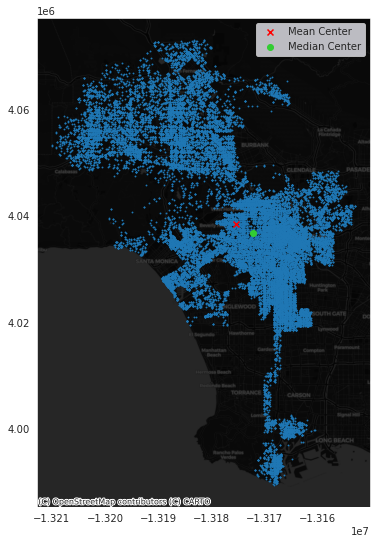

In [54]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(df['x'], df['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

ax.legend()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
# Display
plt.show()

In [55]:
#Dispersion and Orientation 
major, minor, rotation = centrography.ellipse(df[['x','y']])


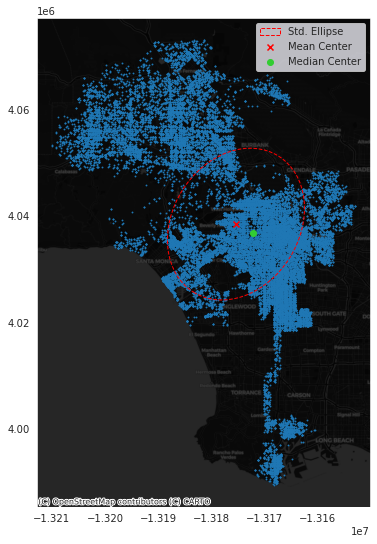

In [56]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(df['x'], df['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

# Display
plt.show()


In [57]:
#Create a function to put all of the previous section together 

@interact
def crime_ellipse(race=df.race.unique().tolist()):
    # filter the data by race
    crime_filtered = df[df.race == race]

    # mean center and median
    mean_center = centrography.mean_center(crime_filtered[['x','y']])
    med_center = centrography.euclidean_median(crime_filtered[['x','y']])

    # standard ellipse
    major, minor, rotation = centrography.ellipse(crime_filtered[['x','y']])

    # Set up figure and axis
    f, ax = plt.subplots(1, figsize=(9, 9))

    # plot arrest points
    ax.scatter(crime_filtered['x'], crime_filtered['y'], s=0.75)

    # add the mean and median center points
    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    # heatmap
    sns.kdeplot(x = crime_filtered.geometry.x, 
                y = crime_filtered.geometry.y,
                n_levels=20, 
                shade=False,
                thresh=0.1,
                alpha=0.3, 
                cmap='Reds', 
                ax=ax)

    # Construct the standard ellipse using matplotlib
    ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                      width=major*2, # centrography.ellipse db_filtered
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')

    ax.add_patch(ellipse)

    ax.legend()

    ax.axis('Off')

    ax.set_title(str(len(crime_filtered)) + ' incidents of crime with reported victim descent "' + race + '"')

    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
    # Display
    plt.show()

interactive(children=(Dropdown(description='race', options=('H', 'W', 'B', 'O', 'A', 'X', 'G', 'V', 'K', 'F', …

In [58]:
#Create a function to put all of the previous section together 

@interact
def crime_ellipse(race=df.race.unique().tolist(),
                  crime=df.crime.unique().tolist()):
    # filter the data by race
    crime_filtered = df[(df.race == race)&(df.crime==crime)]

    # mean center and median
    mean_center = centrography.mean_center(crime_filtered[['x','y']])
    med_center = centrography.euclidean_median(crime_filtered[['x','y']])

    # standard ellipse
    major, minor, rotation = centrography.ellipse(crime_filtered[['x','y']])

    # Set up figure and axis
    f, ax = plt.subplots(1, figsize=(9, 9))

    # plot arrest points
    ax.scatter(crime_filtered['x'], crime_filtered['y'], s=0.75)

    # add the mean and median center points
    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    # heatmap
    sns.kdeplot(x = crime_filtered.geometry.x, 
                y = crime_filtered.geometry.y,
                n_levels=20, 
                shade=False,
                thresh=0.1,
                alpha=0.3, 
                cmap='Reds', 
                ax=ax)

    # Construct the standard ellipse using matplotlib
    ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                      width=major*2, # centrography.ellipse db_filtered
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')

    ax.add_patch(ellipse)

    ax.legend()

    ax.axis('Off')

    ax.set_title(str(len(crime_filtered)) + ' incidents of crime with reported crime type (by race) "' + crime + '"')

    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
    # Display
    plt.show()

interactive(children=(Dropdown(description='race', options=('H', 'W', 'B', 'O', 'A', 'X', 'G', 'V', 'K', 'F', …

This KDE plot demonstrates the location of specific crimes by race within the Los Angeles area. This informs our analysis in that it provides us with a much richer and deeper understanding of where crime types occur specifically by race and provides us with some highly informative statistics. 

For this assignment, Donna focused on conducting a spatial autocorrelation analysis and Daniel focused on conducting a thorough point pattern analysis of the dataset. 